In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
from torchvision.transforms import RandomRotation, RandomHorizontalFlip, ColorJitter
import torch.nn.functional as F
from sklearn.metrics import accuracy_score

In [2]:
# transformations
transform_augmented = transforms.Compose([
    transforms.RandomRotation(degrees=10),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

transform_standard = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [3]:
torch.manual_seed(42)
np.random.seed(42)

In [4]:
train_data = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform_standard)
test_data = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform_standard)

In [5]:
# split train data into train and validation
train_size = int(0.8 * len(train_data))
val_size = len(train_data) - train_size
train_data, val_data = torch.utils.data.random_split(train_data, [train_size, val_size])

In [6]:
# data augmentation for train data
train_data.dataset.transform = transform_augmented

In [7]:
# dataloaders
batch_size = 64
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [8]:
# define the first CNN model
class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
net = CustomCNN()

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [10]:
# Lists for saving history
train_loss_history = []
val_loss_history = []
val_accuracy_history = []

# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    net.train()
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 100 == 99:  
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0

    net.eval()
    correct = 0
    total = 0
    val_loss = 0.0
    with torch.no_grad():
        for data in val_loader:
            images, labels = data
            outputs = net(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    val_accuracy_history.append(accuracy)
    val_loss_history.append(val_loss / len(val_loader))
    print('Accuracy on validation set after epoch %d: %d %%' % (epoch + 1, accuracy))
    train_loss_history.append(running_loss / len(train_loader))

print('End of training')

[1,   100] loss: 2.305
[1,   200] loss: 2.298
[1,   300] loss: 2.291
[1,   400] loss: 2.278
[1,   500] loss: 2.246
[1,   600] loss: 2.149
[1,   700] loss: 1.886
Accuracy on validation set after epoch 1: 54 %
[2,   100] loss: 1.245
[2,   200] loss: 1.035
[2,   300] loss: 0.932
[2,   400] loss: 0.900
[2,   500] loss: 0.860
[2,   600] loss: 0.817
[2,   700] loss: 0.795
Accuracy on validation set after epoch 2: 71 %
[3,   100] loss: 0.753
[3,   200] loss: 0.722
[3,   300] loss: 0.733
[3,   400] loss: 0.734
[3,   500] loss: 0.717
[3,   600] loss: 0.676
[3,   700] loss: 0.672
Accuracy on validation set after epoch 3: 74 %
[4,   100] loss: 0.652
[4,   200] loss: 0.655
[4,   300] loss: 0.647
[4,   400] loss: 0.643
[4,   500] loss: 0.617
[4,   600] loss: 0.633
[4,   700] loss: 0.626
Accuracy on validation set after epoch 4: 75 %
[5,   100] loss: 0.615
[5,   200] loss: 0.595
[5,   300] loss: 0.611
[5,   400] loss: 0.586
[5,   500] loss: 0.592
[5,   600] loss: 0.595
[5,   700] loss: 0.568
Accurac

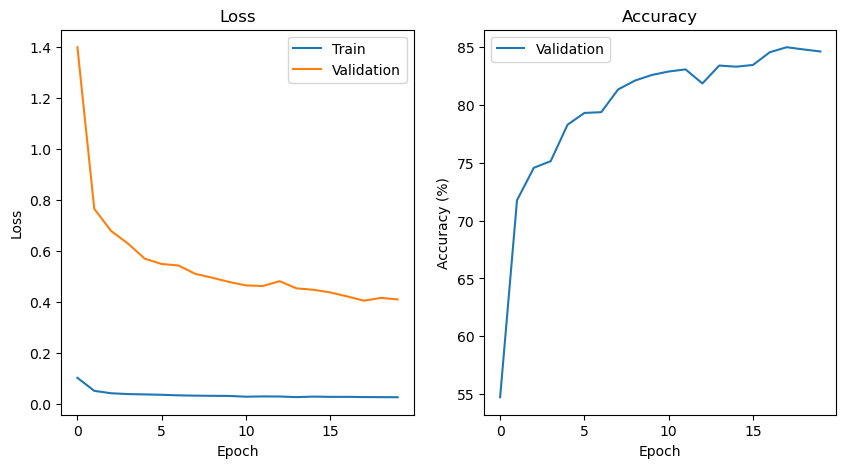

In [11]:
# Plot loss e accuracy
plt.figure(figsize=(10, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(train_loss_history, label='Train')
plt.plot(val_loss_history, label='Validation')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(val_accuracy_history, label='Validation')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()

In [12]:
# test on test set
net.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy on test set: %d %%' % (100 * correct / total))

Accuracy on test set: 85 %


In [13]:
#more complex custom cnn
class CustomNetComplex(nn.Module):
    def __init__(self):
        super(CustomNetComplex, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, 3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(256 * 7 * 7, 512)  
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool1(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool2(x)
        x = x.view(-1, 256 * 7 * 7) 
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net_complex = CustomNetComplex()

In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net_complex.parameters(), lr=0.001, momentum=0.9)

In [15]:
train_loss_history = []
val_loss_history = []
val_accuracy_history = []

num_epochs = 20
for epoch in range(num_epochs):
    net_complex.train()
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data

        optimizer.zero_grad()

        outputs = net_complex(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 100 == 99:  
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0

    net_complex.eval()
    correct = 0
    total = 0
    val_loss = 0.0
    with torch.no_grad():
        for data in val_loader:
            images, labels = data
            outputs = net_complex(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    val_accuracy_history.append(accuracy)
    val_loss_history.append(val_loss / len(val_loader))

    print('Accuracy on validation set after epoch %d: %d %%' % (epoch + 1, accuracy))

    train_loss_history.append(running_loss / len(train_loader))

print('End of training')

[1,   100] loss: 2.302
[1,   200] loss: 2.299
[1,   300] loss: 2.295
[1,   400] loss: 2.283
[1,   500] loss: 2.213
[1,   600] loss: 1.436
[1,   700] loss: 0.973
Accuracy on validation set after epoch 1: 66 %
[2,   100] loss: 0.846
[2,   200] loss: 0.765
[2,   300] loss: 0.770
[2,   400] loss: 0.743
[2,   500] loss: 0.679
[2,   600] loss: 0.686
[2,   700] loss: 0.668
Accuracy on validation set after epoch 2: 76 %
[3,   100] loss: 0.665
[3,   200] loss: 0.639
[3,   300] loss: 0.629
[3,   400] loss: 0.658
[3,   500] loss: 0.600
[3,   600] loss: 0.620
[3,   700] loss: 0.586
Accuracy on validation set after epoch 3: 77 %
[4,   100] loss: 0.580
[4,   200] loss: 0.590
[4,   300] loss: 0.585
[4,   400] loss: 0.574
[4,   500] loss: 0.532
[4,   600] loss: 0.542
[4,   700] loss: 0.538
Accuracy on validation set after epoch 4: 80 %
[5,   100] loss: 0.540
[5,   200] loss: 0.528
[5,   300] loss: 0.507
[5,   400] loss: 0.525
[5,   500] loss: 0.507
[5,   600] loss: 0.494
[5,   700] loss: 0.509
Accurac

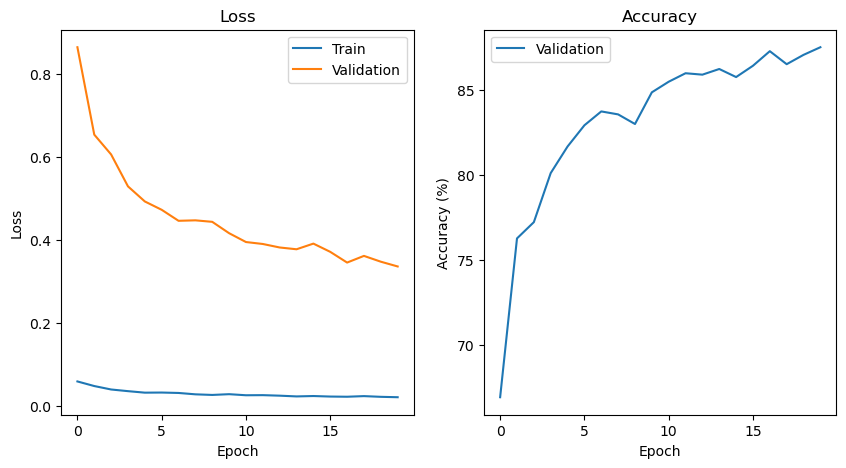

In [16]:
plt.figure(figsize=(10, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(train_loss_history, label='Train')
plt.plot(val_loss_history, label='Validation')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(val_accuracy_history, label='Validation')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()

In [17]:
net_complex.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = net_complex(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy on test set: %d %%' % (100 * correct / total))

Accuracy on test set: 87 %


In [18]:
class CustomCNNComplex(nn.Module):
    def __init__(self):
        super(CustomCNNComplex, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, 3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(256 * 7 * 7, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)
        self.dropout = nn.Dropout(p=0.5)  

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool1(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool2(x)
        x = x.view(-1, 256 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)  
        x = F.relu(self.fc2(x))
        x = self.dropout(x)  
        x = self.fc3(x)
        return x

net_complex2 = CustomCNNComplex()

In [19]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net_complex2.parameters(), lr=0.001)

[1,   100] loss: 1.247
[1,   200] loss: 0.684
[1,   300] loss: 0.595
[1,   400] loss: 0.527
[1,   500] loss: 0.510
[1,   600] loss: 0.486
[1,   700] loss: 0.437
Accuracy on validation set after epoch 1: 85.72%
[2,   100] loss: 0.411
[2,   200] loss: 0.409
[2,   300] loss: 0.402
[2,   400] loss: 0.405
[2,   500] loss: 0.380
[2,   600] loss: 0.361
[2,   700] loss: 0.354
Accuracy on validation set after epoch 2: 88.22%
[3,   100] loss: 0.324
[3,   200] loss: 0.339
[3,   300] loss: 0.333
[3,   400] loss: 0.329
[3,   500] loss: 0.318
[3,   600] loss: 0.311
[3,   700] loss: 0.333
Accuracy on validation set after epoch 3: 90.19%
[4,   100] loss: 0.291
[4,   200] loss: 0.300
[4,   300] loss: 0.314
[4,   400] loss: 0.284
[4,   500] loss: 0.286
[4,   600] loss: 0.285
[4,   700] loss: 0.282
Accuracy on validation set after epoch 4: 89.85%
[5,   100] loss: 0.282
[5,   200] loss: 0.264
[5,   300] loss: 0.272
[5,   400] loss: 0.285
[5,   500] loss: 0.278
[5,   600] loss: 0.263
[5,   700] loss: 0.280

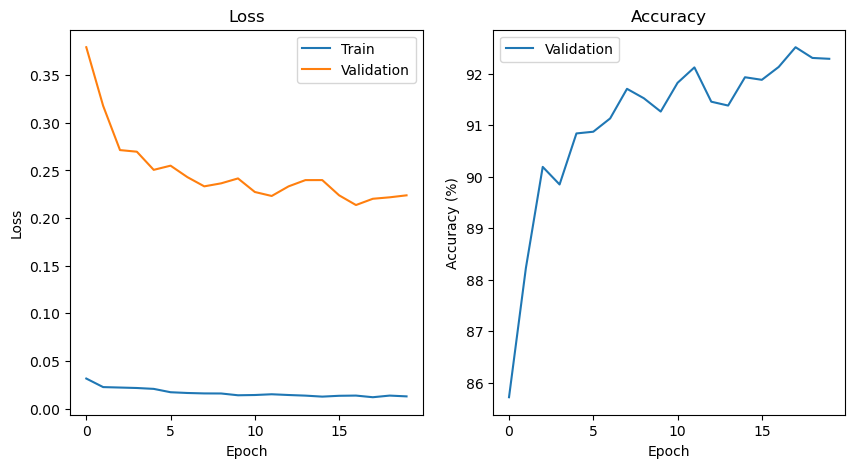

In [20]:
train_loss_history = []
val_loss_history = []
val_accuracy_history = []

# Addestramento della rete
num_epochs = 20
for epoch in range(num_epochs):
    net_complex2.train()
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data

        optimizer.zero_grad()

        outputs = net_complex2(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 100 == 99:  
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0

    # Valutazione sul set di validazione
    net_complex2.eval()
    correct = 0
    total = 0
    val_loss = 0.0
    with torch.no_grad():
        for data in val_loader:
            images, labels = data
            outputs = net_complex2(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Calcola l'accuratezza e la perdita sul set di validazione
    accuracy = 100 * correct / total
    val_accuracy_history.append(accuracy)
    val_loss_history.append(val_loss / len(val_loader))

    # Stampa l'accuratezza sul set di validazione
    print('Accuracy on validation set after epoch %d: %.2f%%' % (epoch + 1, accuracy))

    # Salva la perdita sul set di addestramento
    train_loss_history.append(running_loss / len(train_loader))

print('End of training')

# Plot loss e accuracy
plt.figure(figsize=(10, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(train_loss_history, label='Train')
plt.plot(val_loss_history, label='Validation')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(val_accuracy_history, label='Validation')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()

In [21]:
net_complex2.eval()
true_labels = []
pred_labels = []
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = net_complex2(images)
        _, predicted = torch.max(outputs.data, 1)
        true_labels.extend(labels.numpy())
        pred_labels.extend(predicted.numpy())

# Calcola l'accuratezza utilizzando sklearn
accuracy = accuracy_score(true_labels, pred_labels) * 100
print('Accuracy on test set: {:.2f}%'.format(accuracy))

Accuracy on test set: 92.52%


In [22]:
class CustomCNNComplex3(nn.Module):
    def __init__(self):
        super(CustomCNNComplex3, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, 3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(256 * 7 * 7, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)
        self.dropout = nn.Dropout(p=0.3)  

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool1(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool2(x)
        x = x.view(-1, 256 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)  
        x = F.relu(self.fc2(x))
        x = self.dropout(x)  
        x = self.fc3(x)
        return x

net_complex3 = CustomCNNComplex3()

In [23]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net_complex2.parameters(), lr=0.001)

[1,   100] loss: 2.303
[1,   200] loss: 2.303
[1,   300] loss: 2.304
[1,   400] loss: 2.303
[1,   500] loss: 2.304
[1,   600] loss: 2.304
[1,   700] loss: 2.303
Accuracy on validation set after epoch 1: 9.96%
[2,   100] loss: 2.303
[2,   200] loss: 2.303
[2,   300] loss: 2.304
[2,   400] loss: 2.303
[2,   500] loss: 2.303
[2,   600] loss: 2.304
[2,   700] loss: 2.303
Accuracy on validation set after epoch 2: 9.96%
[3,   100] loss: 2.303
[3,   200] loss: 2.304
[3,   300] loss: 2.304
[3,   400] loss: 2.303
[3,   500] loss: 2.303
[3,   600] loss: 2.303
[3,   700] loss: 2.303
Accuracy on validation set after epoch 3: 9.96%
[4,   100] loss: 2.303
[4,   200] loss: 2.303
[4,   300] loss: 2.303
[4,   400] loss: 2.303
[4,   500] loss: 2.304
[4,   600] loss: 2.303
[4,   700] loss: 2.303
Accuracy on validation set after epoch 4: 9.96%
[5,   100] loss: 2.304
[5,   200] loss: 2.304
[5,   300] loss: 2.303
[5,   400] loss: 2.303
[5,   500] loss: 2.303
[5,   600] loss: 2.303
[5,   700] loss: 2.303
Acc

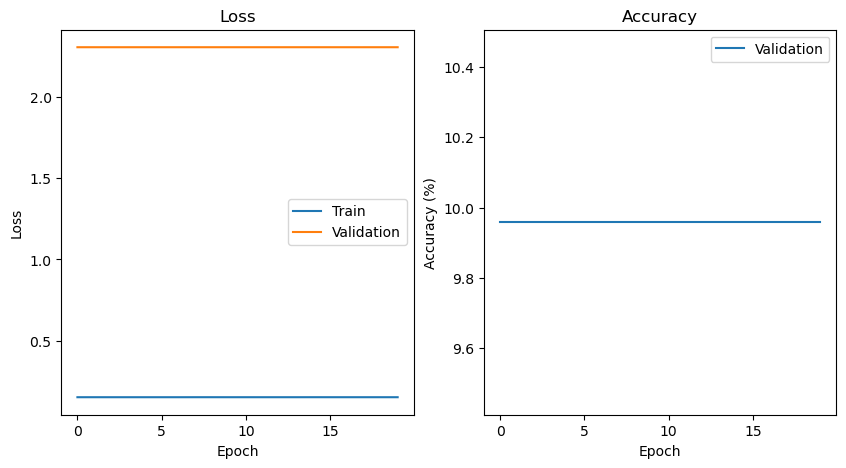

In [24]:
train_loss_history = []
val_loss_history = []
val_accuracy_history = []

# Addestramento della rete
num_epochs = 20
for epoch in range(num_epochs):
    net_complex3.train()
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data

        optimizer.zero_grad()

        outputs = net_complex3(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 100 == 99:  
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0

    # Valutazione sul set di validazione
    net_complex3.eval()
    correct = 0
    total = 0
    val_loss = 0.0
    with torch.no_grad():
        for data in val_loader:
            images, labels = data
            outputs = net_complex3(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Calcola l'accuratezza e la perdita sul set di validazione
    accuracy = 100 * correct / total
    val_accuracy_history.append(accuracy)
    val_loss_history.append(val_loss / len(val_loader))

    # Stampa l'accuratezza sul set di validazione
    print('Accuracy on validation set after epoch %d: %.2f%%' % (epoch + 1, accuracy))

    # Salva la perdita sul set di addestramento
    train_loss_history.append(running_loss / len(train_loader))

print('End of training')

# Plot loss e accuracy
plt.figure(figsize=(10, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(train_loss_history, label='Train')
plt.plot(val_loss_history, label='Validation')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(val_accuracy_history, label='Validation')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()

In [25]:
net_complex3.eval()
true_labels = []
pred_labels = []
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = net_complex3(images)
        _, predicted = torch.max(outputs.data, 1)
        true_labels.extend(labels.numpy())
        pred_labels.extend(predicted.numpy())

# Calcola l'accuratezza utilizzando sklearn
accuracy = accuracy_score(true_labels, pred_labels) * 100
print('Accuracy on test set: {:.2f}%'.format(accuracy))

Accuracy on test set: 10.00%
